In [ ]:
# Install dependencies
!pip install -q kaggle
!pip install -q transformers datasets evaluate accelerate xgboost wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()  # choose kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"brianyoe","key":"afce5fbb31da05ba127a14d167e4fc13"}'}

In [ ]:
# Configure kaggle & download dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset -q
!unzip -q fake-and-real-news-dataset.zip -d fake_news

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0


In [ ]:
# Load & merge CSV files
import pandas as pd
pd.options.display.max_colwidth = 200

fake = pd.read_csv("fake_news/Fake.csv")
real = pd.read_csv("fake_news/True.csv")

fake['label'] = 0
real['label'] = 1

df = pd.concat([fake, real], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
df['content'] = df['title'].fillna('') + " " + df['text'].fillna('')
df = df.drop_duplicates(subset=['content']).reset_index(drop=True)
print("Total articles:", len(df))
df.head(3)


Total articles: 39105


,title,text,subject,date,label,content
0,Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution,"21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocati...",US_News,"February 13, 2017",0,"Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood ..."
1,Trump drops Steve Bannon from National Security Council,"WASHINGTON (Reuters) - U.S. President Donald Trump removed his chief strategist Steve Bannon from the National Security Council on Wednesday, reversing his controversial decision early this year t...",politicsNews,"April 5, 2017",1,Trump drops Steve Bannon from National Security Council WASHINGTON (Reuters) - U.S. President Donald Trump removed his chief strategist Steve Bannon from the National Security Council on Wednesday...
2,Puerto Rico expects U.S. to lift Jones Act shipping restrictions,"(Reuters) - Puerto Rico Governor Ricardo Rossello said on Wednesday he expected the federal government to waive the Jones Act, which would lift restrictions on ships that can provide aid to the is...",politicsNews,"September 27, 2017",1,"Puerto Rico expects U.S. to lift Jones Act shipping restrictions (Reuters) - Puerto Rico Governor Ricardo Rossello said on Wednesday he expected the federal government to waive the Jones Act, whic..."


In [ ]:
# Preprocessing function: lowercasing, remove non-letters, remove stopwords
import re
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)          # removes urls
    text = re.sub(r'[^a-z\s]', ' ', text)        # keeps letters + spaces
    tokens = [t for t in text.split() if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

# Apply cleaning to entire df
df['clean'] = df['content'].apply(clean_text)

# Quick sanity check
df[['content','clean']].head(3)


,content,clean
0,"Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood ...",ben stein calls th circuit court committed coup tat constitution st century wire says ben stein reputable professor pepperdine university also hollywood fame appearing tv shows films ferris buelle...
1,Trump drops Steve Bannon from National Security Council WASHINGTON (Reuters) - U.S. President Donald Trump removed his chief strategist Steve Bannon from the National Security Council on Wednesday...,trump drops steve bannon national security council washington reuters president donald trump removed chief strategist steve bannon national security council wednesday reversing controversial decis...
2,"Puerto Rico expects U.S. to lift Jones Act shipping restrictions (Reuters) - Puerto Rico Governor Ricardo Rossello said on Wednesday he expected the federal government to waive the Jones Act, whic...",puerto rico expects lift jones act shipping restrictions reuters puerto rico governor ricardo rossello said wednesday expected federal government waive jones act would lift restrictions ships prov...


In [ ]:
# Train / Test split (stratified)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df['label'])
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (31284, 7)
Test shape: (7821, 7)


In [ ]:
# TF-IDF vectorization (for classical models)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_df['clean'])
X_test_tfidf = tfidf.transform(test_df['clean'])
y_train = train_df['label'].values
y_test = test_df['label'].values

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)


TF-IDF shapes: (31284, 10000) (7821, 10000)


In [ ]:
# Linear SVM (train & evaluate)
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

svm = LinearSVC(max_iter=20000, random_state=42)
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, digits=4))

Linear SVM Accuracy: 0.9943741209563994
              precision    recall  f1-score   support

           0     0.9955    0.9922    0.9938      3582
           1     0.9934    0.9962    0.9948      4239

    accuracy                         0.9944      7821
   macro avg     0.9945    0.9942    0.9943      7821
weighted avg     0.9944    0.9944    0.9944      7821



In [ ]:
# XGBoost (train & evaluate)
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_clf.predict(X_test_tfidf)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, digits=4))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:34:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9970591995908452
              precision    recall  f1-score   support

           0     0.9986    0.9950    0.9968      3582
           1     0.9958    0.9988    0.9973      4239

    accuracy                         0.9971      7821
   macro avg     0.9972    0.9969    0.9970      7821
weighted avg     0.9971    0.9971    0.9971      7821



In [ ]:
# Disable Weights & Biases to avoid login prompt
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

In [ ]:
# Prepare HuggingFace datasets for transformers
from datasets import Dataset

# Use raw content (not aggressive cleaned text) for transformers
train_hf = Dataset.from_pandas(train_df[['content','label']].reset_index(drop=True))
test_hf = Dataset.from_pandas(test_df[['content','label']].reset_index(drop=True))

print(train_hf[0])

{'content': 'ANOTHER CLINTON CASUALTY? Activist MURDERED After Openly Blaming HILLARY For Meddling Role In Honduran Coup [VIDEO] When far left publications like Democracy Now and Global Research start questioning Hillary s involvement in the murder of Honduran environmental activist, Berta C ceres, there is probably good reason to look a little deeper into the controversy. Former Secretary of State Hillary Clinton is facing a new round of questions about her handling of the 2009 coup in Honduras that ousted democratically elected President Manuel Zelaya. Since the coup, Honduras has become one of the most violent places in the world. Last week, indigenous environmental activist Berta C ceres was assassinated in her home.Before her murder on March 3, Berta C ceres, a Honduran indigenous rights and environmental activist, named Hillary Clinton, holding her responsible for legitimating the 2009 coup.  We warned that this would be very dangerous,  she said, referring to Clinton s effort to

In [ ]:
# Metrics using `evaluate`
import evaluate
import numpy as np

acc_metric = evaluate.load("accuracy")
prec_metric = evaluate.load("precision")
rec_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "precision": prec_metric.compute(predictions=preds, references=labels)["precision"],
        "recall": rec_metric.compute(predictions=preds, references=labels)["recall"],
        "f1": f1_metric.compute(predictions=preds, references=labels)["f1"],
    }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Tokenize (DistilBERT tokenizer) & prepare datasets
from transformers import AutoTokenizer

distil_name = "distilbert-base-uncased"
distil_tokenizer = AutoTokenizer.from_pretrained(distil_name)

def tokenize_fn(batch):
    return distil_tokenizer(batch["content"], truncation=True, padding="max_length", max_length=256)

train_tok = train_hf.map(tokenize_fn, batched=True)
test_tok = test_hf.map(tokenize_fn, batched=True)

# Remove original text column and set format for PyTorch
train_tok = train_tok.remove_columns(["content"])
test_tok = test_tok.remove_columns(["content"])
train_tok.set_format(type="torch")
test_tok.set_format(type="torch")

print(train_tok)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/31284 [00:00<?, ? examples/s]

Map:   0%|          | 0/7821 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 31284
})


In [ ]:
# Train DistilBERT (fine-tune)
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

distil_model = AutoModelForSequenceClassification.from_pretrained(distil_name, num_labels=2)

distil_args = TrainingArguments(
    output_dir="distilbert-output",
    eval_strategy="epoch",        # updated API name
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

distil_trainer = Trainer(
    model=distil_model,
    args=distil_args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    compute_metrics=compute_metrics
)

distil_trainer.train()
distil_eval = distil_trainer.evaluate()
print("DistilBERT eval:", distil_eval)


⚙️  Running in WANDB offline mode


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.003800,0.001839,0.999744,1.000000,0.999528,0.999764
2,0.000000,0.003129,0.999616,0.999764,0.999528,0.999646


DistilBERT eval: {'eval_loss': 0.0018394174985587597, 'eval_accuracy': 0.9997442782252909, 'eval_precision': 1.0, 'eval_recall': 0.9995281906109932, 'eval_f1': 0.9997640396413403, 'eval_runtime': 54.6804, 'eval_samples_per_second': 143.031, 'eval_steps_per_second': 8.943, 'epoch': 2.0}


In [ ]:
# Tokenize & Train BERT-base (heavier)
from transformers import AutoTokenizer, AutoModelForSequenceClassification

bert_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_name)

def tokenize_fn_bert(batch):
    return bert_tokenizer(batch["content"], truncation=True, padding="max_length", max_length=256)

train_tok_bert = train_hf.map(tokenize_fn_bert, batched=True)
test_tok_bert = test_hf.map(tokenize_fn_bert, batched=True)

train_tok_bert = train_tok_bert.remove_columns(["content"])
test_tok_bert = test_tok_bert.remove_columns(["content"])
train_tok_bert.set_format(type="torch")
test_tok_bert.set_format(type="torch")

bert_model = AutoModelForSequenceClassification.from_pretrained(bert_name, num_labels=2)

bert_args = TrainingArguments(
    output_dir="bert-output",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

bert_trainer = Trainer(
    model=bert_model,
    args=bert_args,
    train_dataset=train_tok_bert,
    eval_dataset=test_tok_bert,
    compute_metrics=compute_metrics
)

bert_trainer.train()
bert_eval = bert_trainer.evaluate()
print("BERT eval:", bert_eval)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/31284 [00:00<?, ? examples/s]

Map:   0%|          | 0/7821 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.012100,0.004723,0.999361,1.000000,0.998820,0.999410
2,0.000000,0.002526,0.999489,1.000000,0.999056,0.999528


BERT eval: {'eval_loss': 0.00252594705671072, 'eval_accuracy': 0.9994885564505818, 'eval_precision': 1.0, 'eval_recall': 0.9990563812219864, 'eval_f1': 0.9995279679018173, 'eval_runtime': 117.6886, 'eval_samples_per_second': 66.455, 'eval_steps_per_second': 8.31, 'epoch': 2.0}


In [ ]:
# Get predictions from transformers and compute metrics
# Helper to predict and get numpy preds
def trainer_predict_np(trainer, dataset):
    out = trainer.predict(dataset)
    logits = out.predictions
    preds = np.argmax(logits, axis=-1)
    return preds

y_pred_distil = trainer_predict_np(distil_trainer, test_tok)
y_pred_bert = trainer_predict_np(bert_trainer, test_tok_bert)

# Classical preds (from earlier)
# y_pred_svm, y_pred_xgb already computed


**Visuals (For Comparisons)**

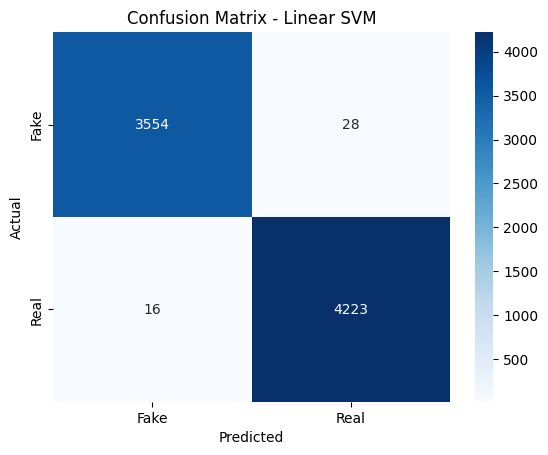

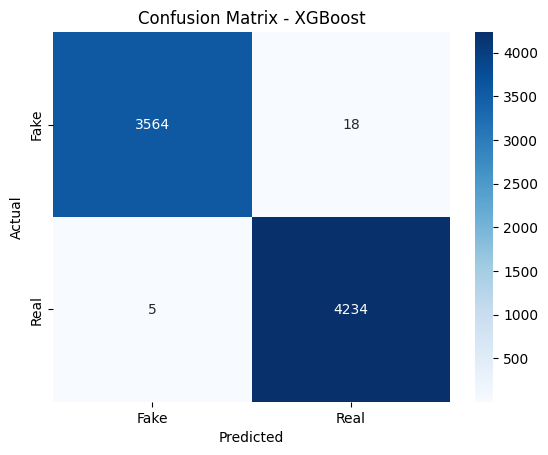

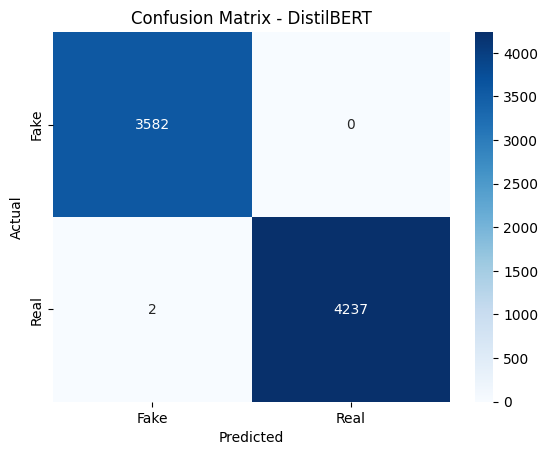

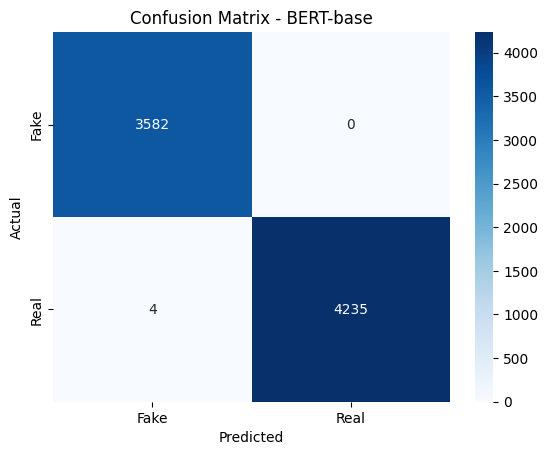

In [ ]:
# Confusion Matrix & comparison plots
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
def plot_cm(y_true, y_pred, title, cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap,
                xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title(title); plt.show()

plot_cm(y_test, y_pred_svm, "Confusion Matrix - Linear SVM")
plot_cm(y_test, y_pred_xgb, "Confusion Matrix - XGBoost")
plot_cm(y_test, y_pred_distil, "Confusion Matrix - DistilBERT")
plot_cm(y_test, y_pred_bert, "Confusion Matrix - BERT-base")


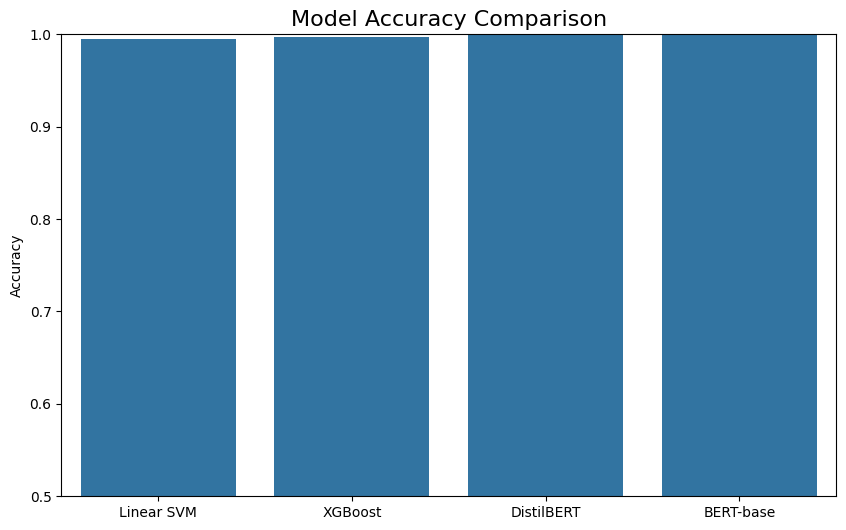

In [ ]:
# Model Accuracy Comparison (Bar Chart)
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ['accuracy']
models = ['Linear SVM', 'XGBoost', 'DistilBERT', 'BERT-base']
values = [
    results['Linear SVM']['accuracy'],
    results['XGBoost']['accuracy'],
    results['DistilBERT']['accuracy'],
    results['BERT-base']['accuracy']
]

plt.figure(figsize=(10,6))
sns.barplot(x=models, y=values)
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.0)
plt.show()

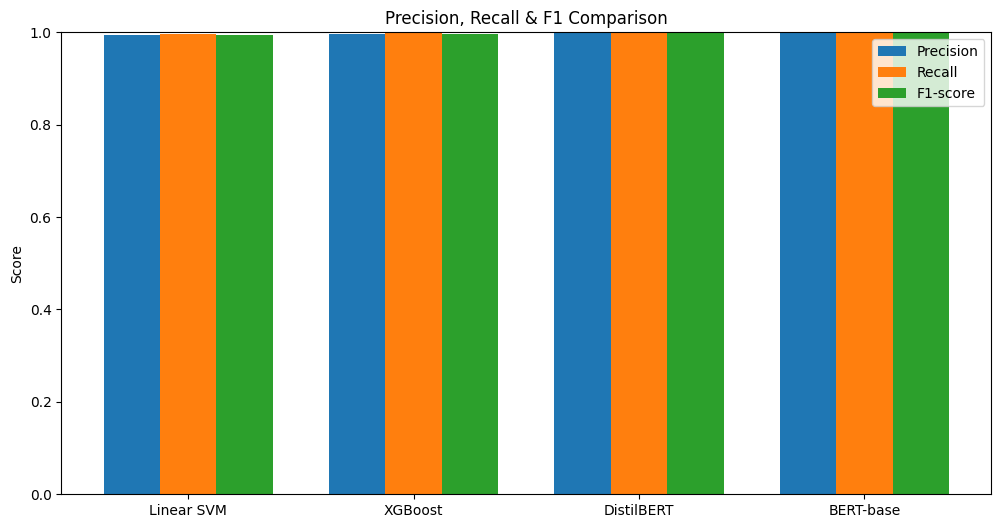

In [ ]:
# Precision, Recall, F1 Comparison (Grouped Bar Chart)
import numpy as np

metrics = ["precision", "recall", "f1"]
model_names = ["Linear SVM", "XGBoost", "DistilBERT", "BERT-base"]

data = np.array([
    [results[m]["precision"] for m in model_names],
    [results[m]["recall"] for m in model_names],
    [results[m]["f1"] for m in model_names]
])

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(12,6))
plt.bar(x - width, data[0], width, label='Precision')
plt.bar(x, data[1], width, label='Recall')
plt.bar(x + width, data[2], width, label='F1-score')

plt.xticks(x, model_names)
plt.title("Precision, Recall & F1 Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend()
plt.show()


<Figure size 1000x800 with 0 Axes>

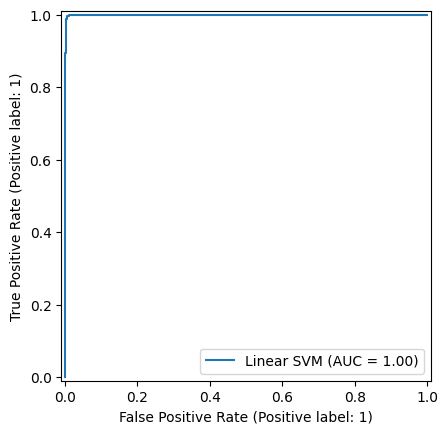

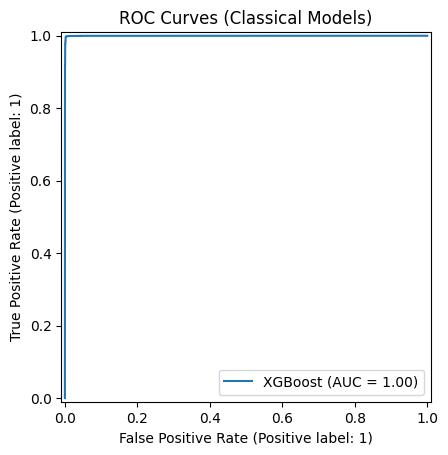

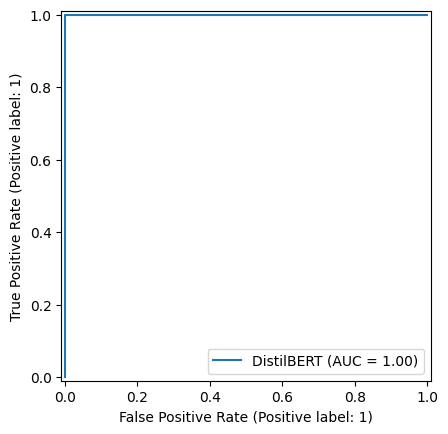

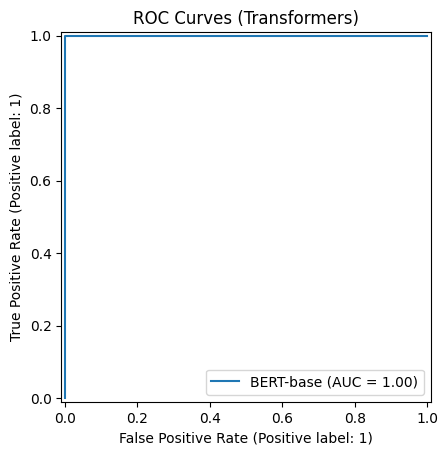

In [ ]:
# ROC Curves for All Models
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(10,8))

for name, preds in [
    ("Linear SVM", svm.decision_function(X_test_tfidf)),
    ("XGBoost", xgb_clf.predict_proba(X_test_tfidf)[:,1])
]:
    RocCurveDisplay.from_predictions(y_test, preds, name=name)

plt.title("ROC Curves (Classical Models)")
plt.show()

# DistilBERT ROC
distil_logits = distil_trainer.predict(test_tok).predictions[:,1]
RocCurveDisplay.from_predictions(y_test, distil_logits, name="DistilBERT")

# BERT-base ROC
bert_logits = bert_trainer.predict(test_tok_bert).predictions[:,1]
RocCurveDisplay.from_predictions(y_test, bert_logits, name="BERT-base")

plt.title("ROC Curves (Transformers)")
plt.show()

In [ ]:
# Create final results table
def get_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

results = {
    "Linear SVM": get_metrics(y_test, y_pred_svm),
    "XGBoost": get_metrics(y_test, y_pred_xgb),
    "DistilBERT": get_metrics(y_test, y_pred_distil),
    "BERT-base": get_metrics(y_test, y_pred_bert)
}

import pandas as pd
results_df = pd.DataFrame(results).T
results_df = results_df[["accuracy","precision","recall","f1"]]
results_df

,accuracy,precision,recall,f1
Linear SVM,0.994374,0.993413,0.996226,0.994817
XGBoost,0.997059,0.995767,0.998820,0.997291
DistilBERT,0.999744,1.000000,0.999528,0.999764
BERT-base,0.999489,1.000000,0.999056,0.999528


In [ ]:
# Save models & vectorizer (optional to run; you can run just in case)
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(svm, "svm_tfidf.pkl")
joblib.dump(xgb_clf, "xgb_tfidf.pkl")

# Save transformers models & tokenizers
distil_trainer.save_model("distilbert_model")
distil_tokenizer.save_pretrained("distilbert_tokenizer")

bert_trainer.save_model("bert_model")
bert_tokenizer.save_pretrained("bert_tokenizer")

print("Saved classical and transformer artifacts.")


Saved classical and transformer artifacts.


In [ ]:
# Quick demo function — predict single article (uses saved SVM & BERT choices)

# Example: predict using SVM (fast) and BERT (robust)
def predict_sample(text, use_models=['svm','distilbert','bert']):
    cleaned = clean_text(text)
    outputs = {}
    if 'svm' in use_models:
        vec = tfidf.transform([cleaned])
        pred = svm.predict(vec)[0]
        outputs['svm'] = "Real" if pred==1 else "Fake"
    if 'xgb' in use_models:
        vec = tfidf.transform([cleaned])
        pred = xgb_clf.predict(vec)[0]
        outputs['xgb'] = "Real" if pred==1 else "Fake"
    if 'distilbert' in use_models:
        tok = distil_tokenizer(text, truncation=True, padding=True, return_tensors="pt", max_length=256)
        out = distil_model(**{k:v.to(distil_model.device) for k,v in tok.items()})
        pred = int(out.logits.argmax().cpu().numpy())
        outputs['distilbert'] = "Real" if pred==1 else "Fake"
    if 'bert' in use_models:
        tok = bert_tokenizer(text, truncation=True, padding=True, return_tensors="pt", max_length=256)
        out = bert_model(**{k:v.to(bert_model.device) for k,v in tok.items()})
        pred = int(out.logits.argmax().cpu().numpy())
        outputs['bert'] = "Real" if pred==1 else "Fake"
    return outputs

# Try example
sample_text = "Breaking: scientists discovered a simple way to reverse aging, experts skeptical"
print(predict_sample(sample_text))


{'svm': 'Fake', 'distilbert': 'Fake', 'bert': 'Fake'}
